In [1]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.stattools as st
import numpy as np
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.cluster import KMeans
from scipy.stats import normaltest
from scipy.optimize import minimize
%matplotlib inline

In [46]:
# specify start and end date here
start_date = '2012-01-01'
end_date = '2021-12-31'

# specify the ticker universe here
tickers = [
    'AAPL', 
    'AMZN', 
    'GOOG', 
    'INTC', 
    'ORCL', 
    'XOM', 
    'CVX', 
    'COP',
    'HES', 
    'OXY'
]

In [47]:
# retrieve universe data
universe = yf.download(tickers, start=start_date, end=end_date)

[*********************100%%**********************]  10 of 10 completed


### Question 1

In [48]:
# get apple daily returns
apple = universe['Close']['AAPL']
daily_returns_apple = apple.pct_change()

# drop naAn values (first row)
daily_returns_apple.dropna(inplace=True)
daily_returns_apple.head()

Date
2012-01-04    0.005374
2012-01-05    0.011102
2012-01-06    0.010454
2012-01-09   -0.001586
2012-01-10    0.003580
Name: AAPL, dtype: float64

<Axes: xlabel='AAPL'>

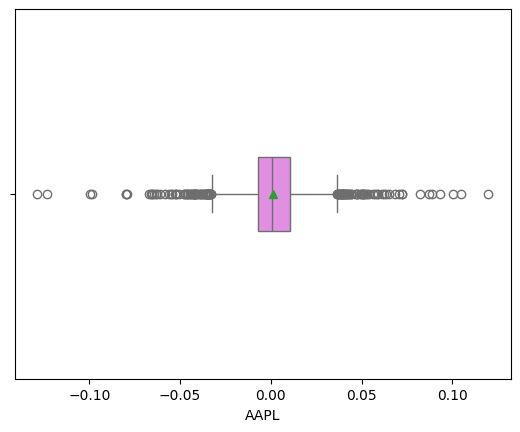

In [49]:
# plot boxplot
sns.boxplot(data=daily_returns_apple, showmeans=True, color="violet", width=0.2, orient="h")  

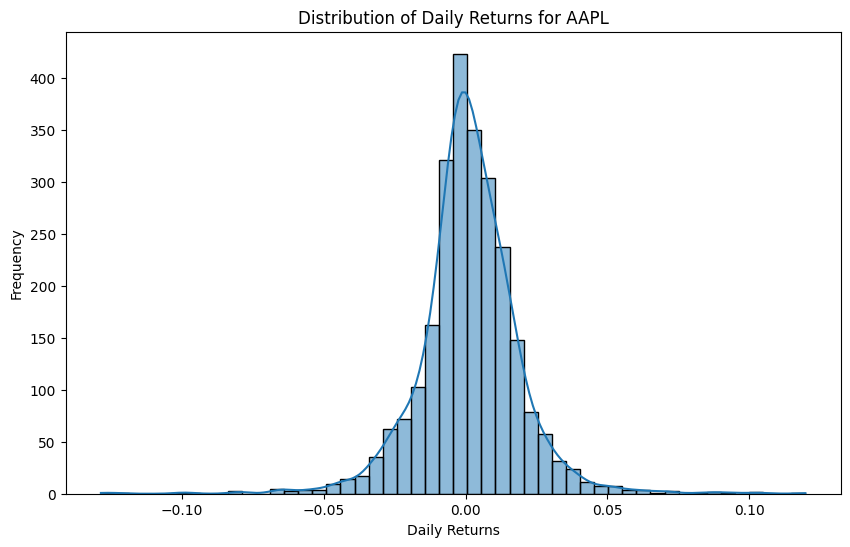

In [50]:
# plot distribution
plt.figure(figsize=(10, 6))
sns.histplot(daily_returns_apple, bins=50, kde=True)
plt.title('Distribution of Daily Returns for AAPL')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.show()


Judging from appearance, the graph seems to be normally distributed. Let's verify this by using the normality function from scipy.normaltest.

In [51]:
# test for normality with scipy.normaltest, derived from D'Agostino and Pearson's test for normality

# H0: the data is normally distributed
# H1: the data is not normally distributed
# p-value: if p-value < 0.05, reject H0
dagostino_test = normaltest(daily_returns_apple)
print(f'Test Statistic: {dagostino_test.statistic}')
print(f'P-Value: {dagostino_test.pvalue}')

Test Statistic: 344.449862303327
P-Value: 1.5983163962405959e-75


The p-value is significantly less than our test-statistic, therefore we can conclude that APPL's returns are normally distributed.

### Question 2

No, we do not use OLS to estimate future trends. Instead, here is the GARCH model for estimating volatility of returns based on past data.

In [52]:
# fetch AAPL
aapl = yf.download('AAPL', start=start_date, end=end_date)
aapl['returns'] = aapl['Close'].pct_change()
# get lagged returns
aapl['lagged_returns'] = aapl['returns'].shift(1)
aapl.dropna(inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [53]:
# durbin watson autocorrelation test
y = aapl['returns']
X = aapl['lagged_returns']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
residuals = model.resid
dw_stat = st.durbin_watson(residuals)
print(f'Durbin-Watson Statistic: {dw_stat}')

Durbin-Watson Statistic: 2.0001458589521994


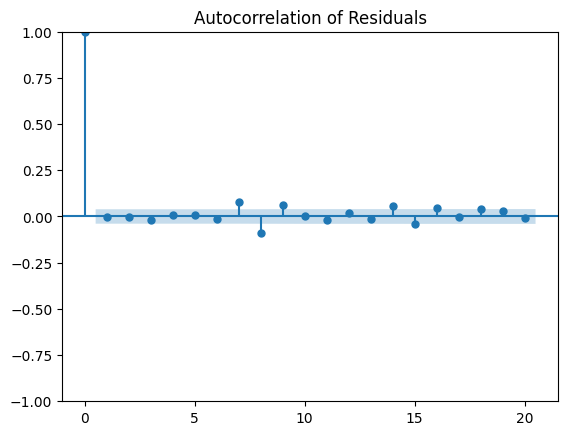

In [54]:
# Plot the autocorrelation function of residuals
plot_acf(residuals, lags=20)
plt.title('Autocorrelation of Residuals')
plt.show()

[*********************100%%**********************]  1 of 1 completed
/Users/joshzheng/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003195. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


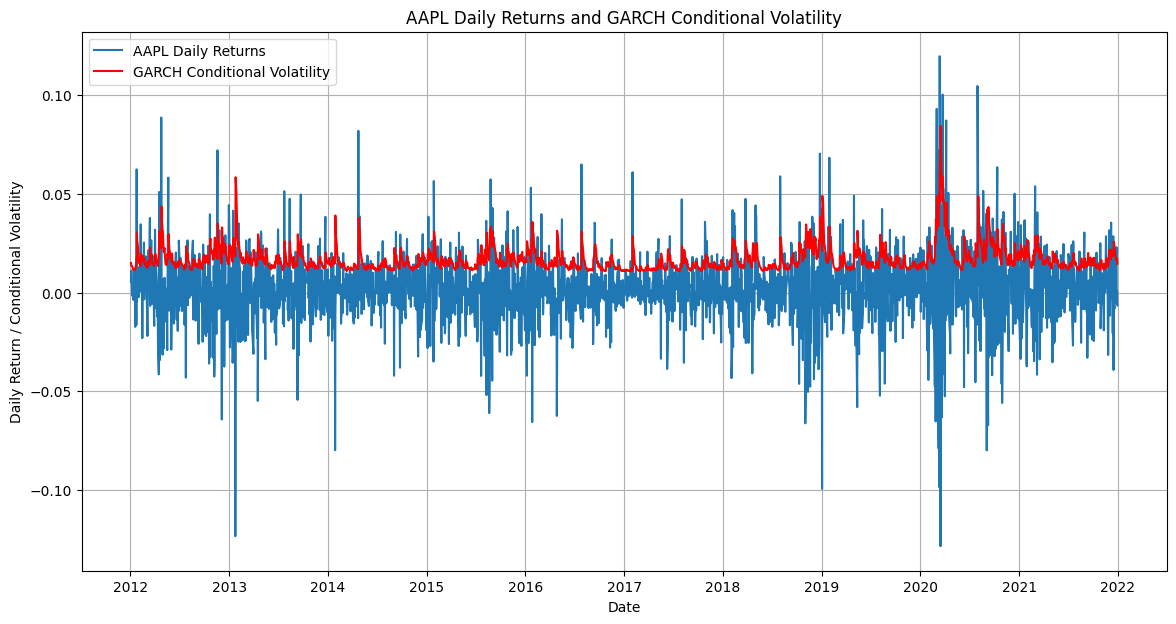

In [55]:
data = yf.download('AAPL', start=start_date, end=end_date)
data = data['Close'].pct_change().dropna()

# fit GARCH(1,1) model
garch_model = arch_model(data, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

# plot the volatility clustering
plt.figure(figsize=(14, 7))
plt.plot(data, label='AAPL Daily Returns')
plt.plot(garch_fit.conditional_volatility, label='GARCH Conditional Volatility', color='red') # rmb conditional_volalitity ** VERY IMPORTANT
plt.title('AAPL Daily Returns and GARCH Conditional Volatility')
plt.xlabel('Date')
plt.ylabel('Daily Return / Conditional Volatility')
plt.legend()
plt.grid(True)
plt.show()

### Question 3

Correlations for daily returns for the stock universe.

In [56]:
# get daily returns for the universe
daily_returns_universe = universe['Close'].pct_change().dropna()

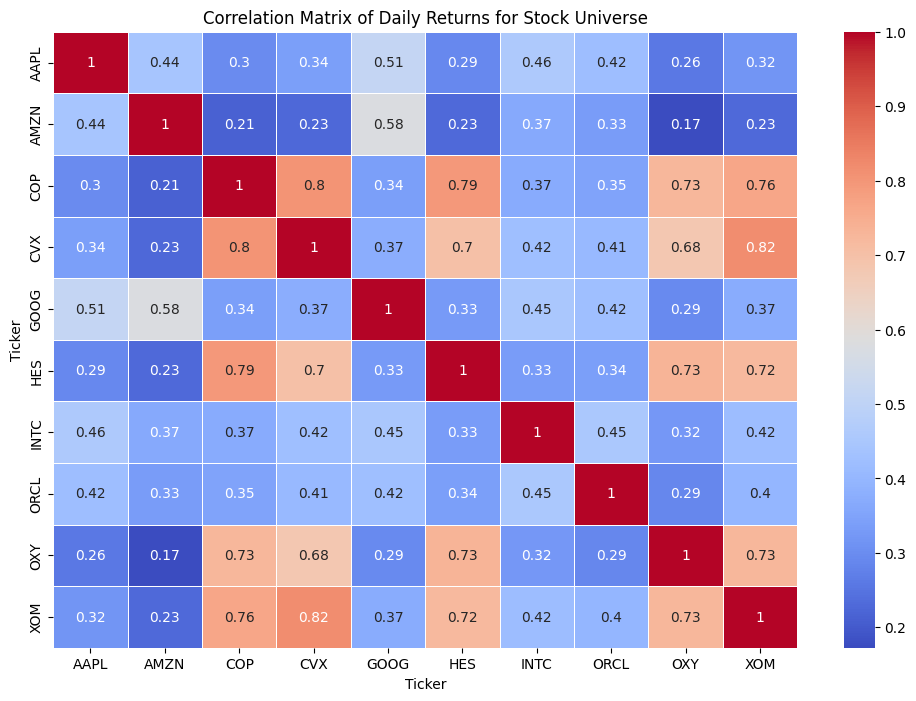

In [57]:
# get correlationmatrix
corr = daily_returns_universe.corr()

# plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Daily Returns for Stock Universe')
plt.show()

### Question 4

In [58]:
# get quarterly returns of stock universe
quarterly_returns = universe.resample('Q').ffill().pct_change().dropna()

In [59]:
# set pandemic period (Q2 2020 to Q4 2021)
pandemic_period = quarterly_returns['Close']['2020-04-01':'2021-12-31'] 

In [60]:
# here are the quarterly returns for the pandemic period
print(pandemic_period.shape)
# 7 features and 10 stocks

(7, 10)


In [61]:
# transpose the data
df = pandemic_period.T

In [62]:
# perform K-means clustering
returns = df.values
kmeans = KMeans(n_clusters=2, random_state=0).fit(returns)
clusters = kmeans.labels_
centroids = kmeans.cluster_centers_

/Users/joshzheng/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [63]:
# add cluster information to the DataFrame
df['Cluster'] = clusters
print(df['Cluster'])

Ticker
AAPL    1
AMZN    1
COP     1
CVX     1
GOOG    1
HES     0
INTC    1
ORCL    1
OXY     0
XOM     1
Name: Cluster, dtype: int32


In [64]:
# define colors for each cluster and map stocks to cluster
cluster_colors = {0: 'red', 1: 'blue'}
stock_colors = [cluster_colors[cluster] for cluster in clusters]

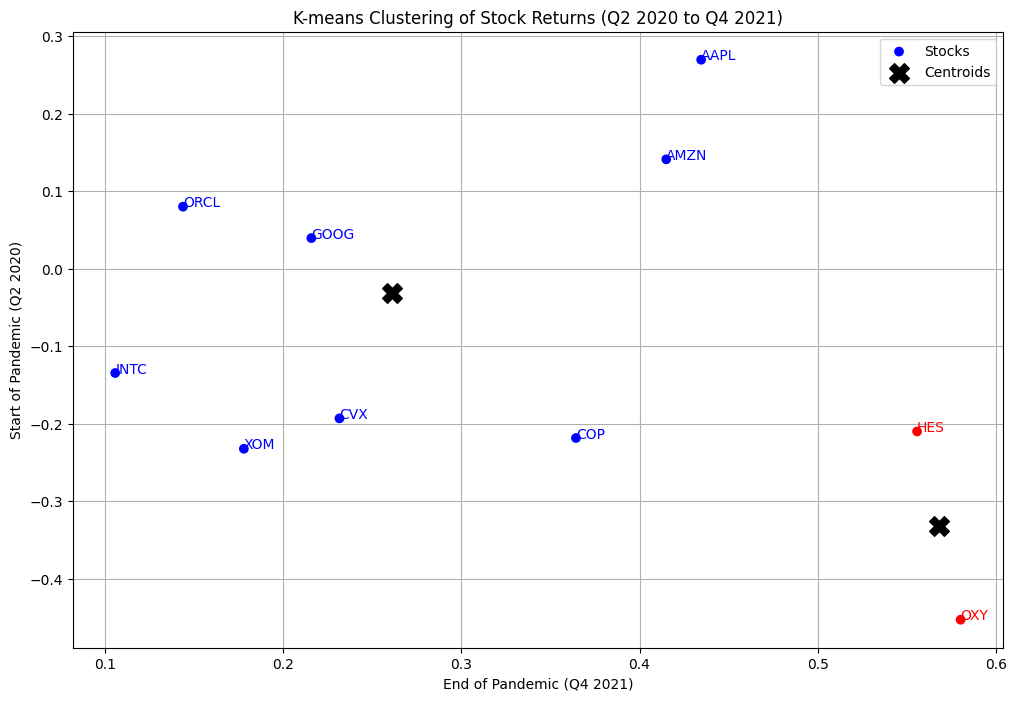

In [65]:
# make plot
plt.figure(figsize=(12, 8))
plt.scatter(returns[:, 0], returns[:, 1], c=stock_colors, marker='o', label='Stocks')
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=200, label='Centroids')

# Annotate each stock
for i, stock in enumerate(df.index):
    plt.annotate(stock, (returns[i, 0], returns[i, 1]), color=stock_colors[i])

plt.xlabel('End of Pandemic (Q4 2021)')
plt.ylabel('Start of Pandemic (Q2 2020)')
plt.title('K-means Clustering of Stock Returns (Q2 2020 to Q4 2021)')
plt.legend()
plt.grid(True)
plt.show()


### Question 5 - Global Minimum Variance Portfolio

In [66]:
def find_min_variance_portfolio(returns):
    # portfolio variance (annualized)
    def portfolio_variance(weights):
        cov_matrix = returns.cov()  # Q
        
        # x^T * Q * x
        annual_variance = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)) * 252)
        return annual_variance

    # Constraint that the sum of the weights is equal to 1
    def weights_sum_to_one(weights):
        return np.sum(weights) - 1

    # Set bounds and constraints
    bounds = [(0, 1) for _ in range(len(returns.columns))]
    initial_weights = [1 / len(returns.columns) for _ in range(len(returns.columns))]
    constraints = {'type': 'eq', 'fun': weights_sum_to_one}

    # Optimize the portfolio
    result = minimize(
        fun=portfolio_variance,
        x0=initial_weights,
        bounds=bounds,
        constraints=constraints,
        method='SLSQP'
    )

    return list(result.x)

In [67]:
# graph
def plot_optimal_weights(weights, tickers, name):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(tickers, weights, color='skyblue')
    plt.xlabel('Stocks')
    plt.ylabel('Portfolio Weights')
    plt.title(f'Optimal Weights for '+name+' Portfolio')
    plt.xticks(rotation=45)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center')

    plt.tight_layout()
    plt.show()

In [68]:
# get the portfolio weights
portfolio_df = universe['Close'].pct_change().dropna()
portfolio_weights = find_min_variance_portfolio(portfolio_df)

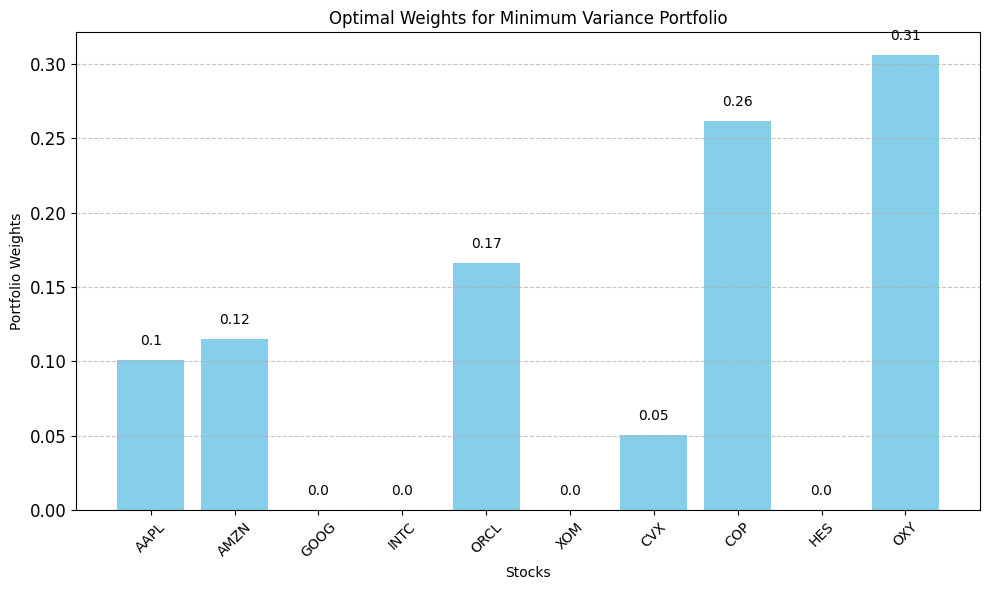

In [69]:
plot_optimal_weights(portfolio_weights, tickers, 'Minimum Variance')

In [70]:
# find optimal sharpe ratio portfolio
# taken from a previous project of mine: https://github.com/joshhzheng/Portfolio-Analysis
def find_sharpe_optimization_portfolio(returns):
    # calculate standard deviation
    def standard_deviation(weights, cov_matrix):
        var = weights.T @ cov_matrix @ weights
        return np.sqrt(var)

    # calculate expected returns (based off historical returns)
    def portfolio_return(weights, log_returns):
        return np.sum(log_returns.mean() * weights) * 252

    # calculate sharpe ratio
    def sharpe_ratio(weights, log_returns, cov_matrix):
        ret = portfolio_return(weights, log_returns)
        std = standard_deviation(weights, cov_matrix)
        return (ret - 0.02) / std   # 2% risk free rate assumption

    # required for minimize function
    def neg_sharpe_ratio(weights, log_returns, cov_matrix):
        return -sharpe_ratio(weights, log_returns, cov_matrix)
    
    # calculate log normal returns
    log_returns = np.log(returns / returns.shift(1))
    log_returns.dropna(inplace=True)
    cov_matrix = log_returns.cov()

    # set bounds and constraints
    bounds = [(0, 0.5) for i in range(len(returns.columns))]
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # initial weights (equal weighted)
    initial_weights = np.array([1/len(returns.columns)]* len(returns.columns))

    # find optimized results
    optimized = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)

    # set optimal weights
    optimized_portfolio = optimized.x
    return optimized_portfolio


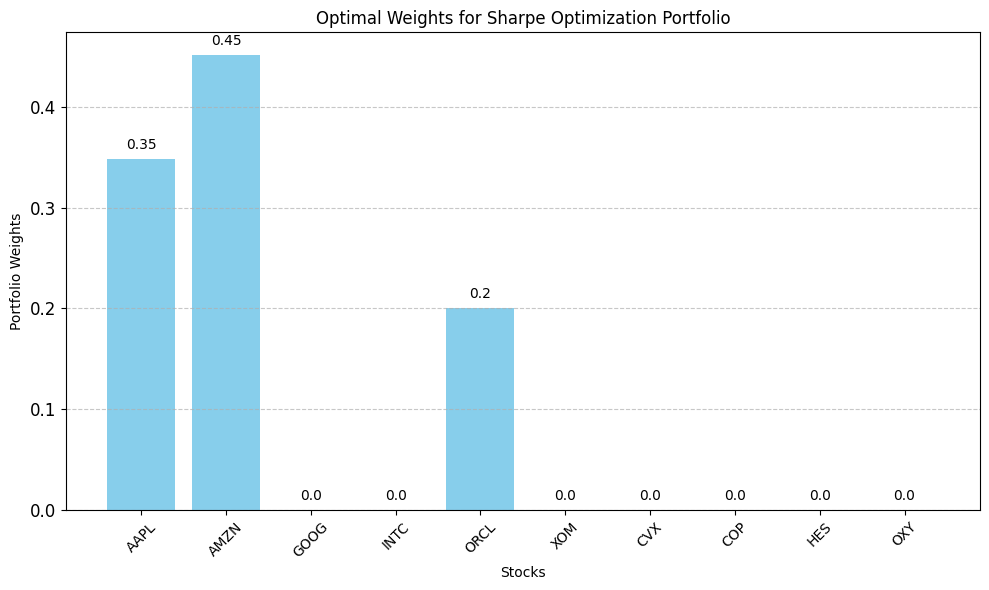

In [42]:
# sharpe portfolio
sharpe_portfolio_df = universe['Close']
sharpe_portfolio = find_sharpe_optimization_portfolio(universe['Close'])
plot_optimal_weights(sharpe_portfolio, tickers, 'Sharpe Optimization')